## Important: Simulation Time Control

**New interface (updated):** The simulators now use `dt` (timestep) and `N_steps` as primary parameters:
- `dt`: Time step for Euler integration (default: 0.001)
- `N_steps`: Number of time steps (default: 10000)  
- `T_total = dt × N_steps` is computed automatically (default: 10.0)

**Choosing `dt`:** For numerical accuracy, use `dt < 0.1 / max(J, gamma)`. The code will warn if stability conditions are violated.

**Example:** For `J=1.0, gamma=1.0`, use `dt=0.01` or smaller. To simulate until time `T=5.0`, use `N_steps=500`.

# Non‑Hermitian measurement simulators

This notebook demonstrates the use of the non‑Hermitian simulators for a monitored XX chain.  Three variants are provided:

- **Hat operator simulator**: evolves the correlation matrix under the imaginary potential associated with continuous monitoring of the fermion number operators.  It records the occupation numbers $\langle n_j 
angle$ and entropy production $Q$.
- **Spin operator simulator**: reuses the same dynamics but reports the magnetisation $\langle \sigma^z_j 
angle = 2 \langle n_j 
angle - 1$ at each site.
- **Adjusted simulator**: subtracts the extensive term $\gamma L$ from the entropy production to facilitate comparison with the analytical curves from Turkeshi's Eq.~(10).

We illustrate their use on a small chain with periodic boundary conditions and explore how the entropy production depends on the measurement rate $\gamma$.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from non_hermitian_hat import NonHermitianHatSimulator
from non_hermitian_spin import NonHermitianSpinSimulator
from non_hermitian_adjusted import NonHermitianAdjustedSimulator


c:\Users\kocho\OneDrive\Documents\VS_code_Projects\Quantom\EP-simulation\quantum_measurement\jw_expansion\non_hermitian_hat.py:1: SyntaxWarning: invalid escape sequence '\s'
  """
c:\Users\kocho\OneDrive\Documents\VS_code_Projects\Quantom\EP-simulation\quantum_measurement\jw_expansion\non_hermitian_hat.py:219: SyntaxWarning: invalid escape sequence '\D'
  """Propagate a single trajectory and compute entropy production.


In [2]:
# Simulation parameters
L = 3          # number of sites
J = 1.0        # coherent hopping strength
N_steps = 10000 # discretisation of total time T=1

# Measurement rates to scan over
gamma_values = np.linspace(0.0, 10.0, 100)

rates_hat = []
rates_spin = []

# Iterate over gamma values and collect entropy per time step
for gamma in gamma_values:
    # Hat simulator (number operators)
    sim_hat = NonHermitianHatSimulator(L=L, J=J, gamma=gamma, N_steps=N_steps, closed_boundary=True)
    Q_hat, n_traj = sim_hat.simulate_trajectory()
    rates_hat.append(Q_hat / N_steps)
    
    # Spin simulator (magnetisation)
    sim_spin = NonHermitianSpinSimulator(L=L, J=J, gamma=gamma, N_steps=N_steps, closed_boundary=True)
    Q_spin, z_traj = sim_spin.simulate_trajectory()
    rates_spin.append(Q_spin / N_steps)
    

rates_hat = np.array(rates_hat)
rates_spin = np.array(rates_spin)


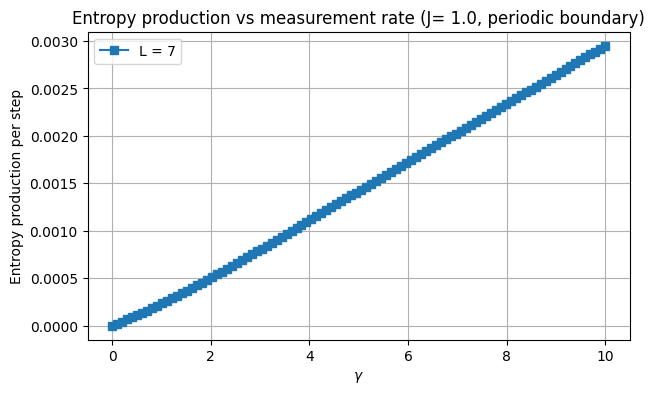

In [3]:
# Plot the entropy production per time step for each simulator
plt.figure(figsize=(7, 4))
plt.plot(gamma_values, rates_spin, 's-', label='L = 7')
plt.xlabel(r'$\gamma$')
plt.ylabel(r'Entropy production per step')
plt.title('Entropy production vs measurement rate (J= 1.0, periodic boundary)')
plt.legend()
plt.grid(True)
plt.show()

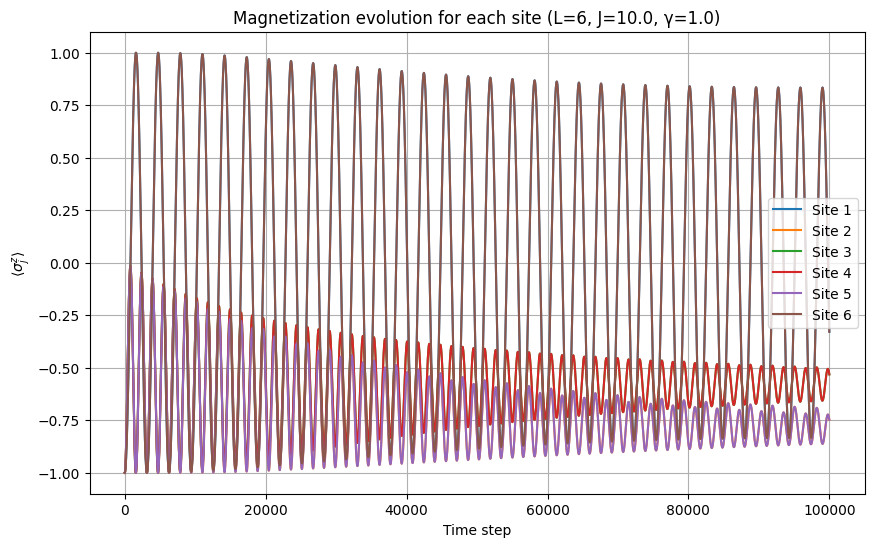

In [2]:
# Plot z_traj(t) for each site from the spin simulator
# Run a single trajectory to visualize time evolution
L = 6
J = 10.0
N_steps = 100000
sim_spin_demo = NonHermitianSpinSimulator(L=L, J=J, gamma=1.0, N_steps=N_steps, closed_boundary=False)
Q_demo, z_traj_demo = sim_spin_demo.simulate_trajectory()

plt.figure(figsize=(10, 6))
time_steps = np.arange(N_steps + 1)
for site in range(L):
    plt.plot(time_steps, z_traj_demo[:, site], label=f'Site {site+1}')

plt.xlabel('Time step')
plt.ylabel(r'$\langle \sigma^z_j \rangle$')
plt.title(f'Magnetization evolution for each site (L={L}, J={J}, γ=1.0)')
plt.legend()
plt.grid(True)
plt.show()


In [5]:
# Simulation parameters
L = 10         # number of sites
J = 1.0        # coherent hopping strength
N_steps = 10000 # discretisation of total time T=1

# Measurement rates to scan over
gamma_values = np.linspace(0.0, 10.0, 100)

rates_adjusted = []

# Iterate over gamma values and collect entropy per time step
for gamma in gamma_values:
    # Adjusted simulator: subtract γ L from the entropy budget
    sim_adj = NonHermitianAdjustedSimulator(L=L, J=J, gamma=gamma, N_steps=N_steps, closed_boundary=True)
    Q_adj, n_traj_adj = sim_adj.simulate_trajectory()
    rates_adjusted.append(Q_adj / N_steps)


rates_adjusted = np.array(rates_adjusted)


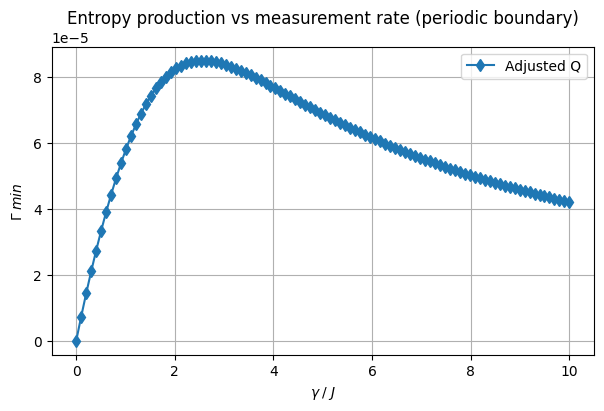

In [6]:
# Plot the entropy production per time step for each simulator
plt.figure(figsize=(7, 4))
gamma_J = gamma_values / J
gamma_min_est = (rates_adjusted) / 4.0
plt.plot(gamma_J, gamma_min_est, 'd-', label='Adjusted Q')
plt.xlabel(r'$\gamma _ / _ J$')
plt.ylabel(r'$\Gamma _ min$')
plt.title('Entropy production vs measurement rate (periodic boundary)')
plt.legend()
plt.grid(True)
plt.show()


In [7]:
# Simulation parameters
L = [6, 7, 8, 9, 10]         # number of sites
J = 1.0        # coherent hopping strength
N_steps = 10000 # discretisation of total time T=1

# Measurement rates to scan over
gamma_values = np.linspace(0.0, 10.0, 100)

rates_adjusted = []
all_rates_arranged = []

# Iterate over gamma values and collect entropy per time step
for l in L:
    for gamma in gamma_values:
        # Adjusted simulator: subtract γ L from the entropy budget
        sim_adj = NonHermitianAdjustedSimulator(L=l, J=J, gamma=gamma, N_steps=N_steps, closed_boundary=True)
        Q_adj, n_traj_adj = sim_adj.simulate_trajectory()
        rates_adjusted.append(Q_adj / N_steps)


    all_rates_arranged.append(np.array(rates_adjusted))
    rates_adjusted = []  # Reset for the next L value

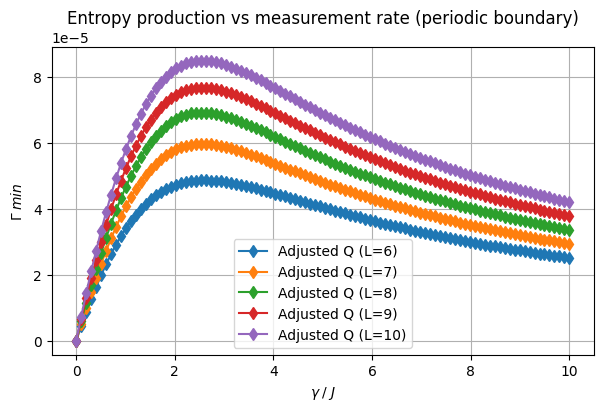

In [8]:
# Plot the entropy production per time step for each simulator
plt.figure(figsize=(7, 4))
gamma_J = gamma_values / J
gamma_min_est = [rates / 4.0 for rates in all_rates_arranged]
for l in L:
    plt.plot(gamma_J, gamma_min_est[l-6], 'd-', label=f'Adjusted Q (L={l})')
plt.xlabel(r'$\gamma _ / _ J$')
plt.ylabel(r'$\Gamma _ min$')
plt.title('Entropy production vs measurement rate (periodic boundary)')
plt.legend()
plt.grid(True)
plt.show()


In [9]:
#now for open boundrey conditions
# Simulation parameters
L = [6, 7, 8, 9, 10]         # number of sites
J = 1.0        # coherent hopping strength
N_steps = 10000 # discretisation of total time T=1

# Measurement rates to scan over
gamma_values = np.linspace(0.0, 10.0, 100)

rates_adjusted = []
all_rates_arranged = []

# Iterate over gamma values and collect entropy per time step
for l in L:
    for gamma in gamma_values:
        # Adjusted simulator: subtract γ L from the entropy budget
        sim_adj = NonHermitianAdjustedSimulator(L=l, J=J, gamma=gamma, N_steps=N_steps, closed_boundary=False)
        Q_adj, n_traj_adj = sim_adj.simulate_trajectory()
        rates_adjusted.append(Q_adj / N_steps)


    all_rates_arranged.append(np.array(rates_adjusted))
    rates_adjusted = []  # Reset for the next L value

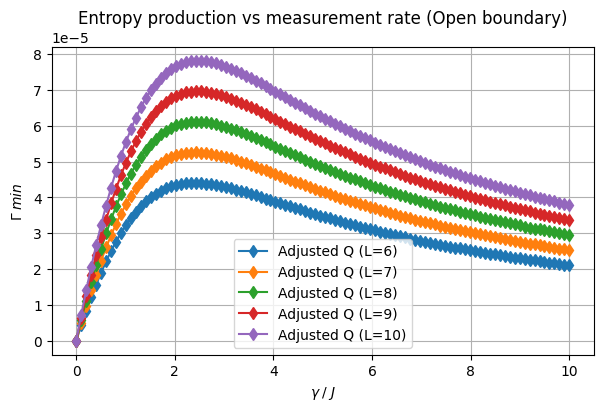

In [10]:
# Plot the entropy production per time step for each simulator
plt.figure(figsize=(7, 4))
gamma_J = gamma_values / J
gamma_min_est = [rates / 4.0 for rates in all_rates_arranged]
for l in L:
    plt.plot(gamma_J, gamma_min_est[l-6], 'd-', label=f'Adjusted Q (L={l})')
plt.xlabel(r'$\gamma _ / _ J$')
plt.ylabel(r'$\Gamma _ min$')
plt.title('Entropy production vs measurement rate (Open boundary)')
plt.legend()
plt.grid(True)
plt.show()


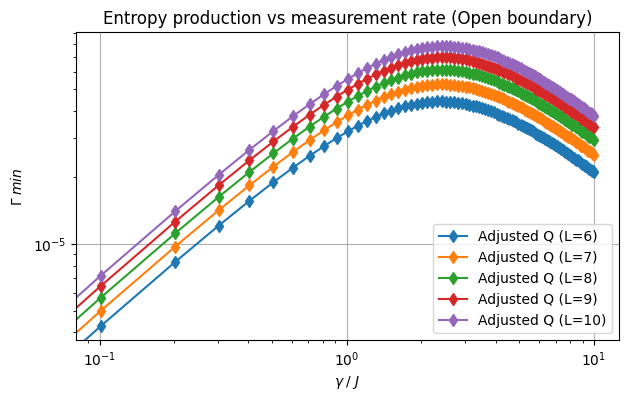

In [11]:
# Plot the entropy production per time step for each simulator
plt.figure(figsize=(7, 4))
gamma_J = gamma_values / J
gamma_min_est = [rates / 4.0 for rates in all_rates_arranged]
for l in L:
    plt.loglog(gamma_J, gamma_min_est[l-6], 'd-', label=f'Adjusted Q (L={l})')
plt.xlabel(r'$\gamma _ / _ J$')
plt.ylabel(r'$\Gamma _ min$')
plt.title('Entropy production vs measurement rate (Open boundary)')
plt.legend()
plt.grid(True)
plt.show()


In [6]:
# new attempt at gamma_min estimation
# Simulation parameters
L = [6, 7, 8, 9, 10]         # number of sites
J = 1.0        # coherent hopping strength
N_steps = 10000 # discretisation of total time T=1

# Measurement rates to scan over
gamma_values = np.linspace(0.0, 10.0, 100)

rates_adjusted = []
all_rates_arranged = []

# Iterate over gamma values and collect entropy per time step
for l in L:
    for gamma in gamma_values:
        # Adjusted simulator: subtract γ L from the entropy budget
        sim_adj = NonHermitianAdjustedSimulator(L=l, J=J, gamma=gamma, N_steps=N_steps, closed_boundary=False)
        Q_adj, n_traj_adj = sim_adj.simulate_trajectory()
        rates_adjusted.append(1/4 * (gamma * l - Q_adj))


    all_rates_arranged.append(np.array(rates_adjusted))
    rates_adjusted = []  # Reset for the next L value

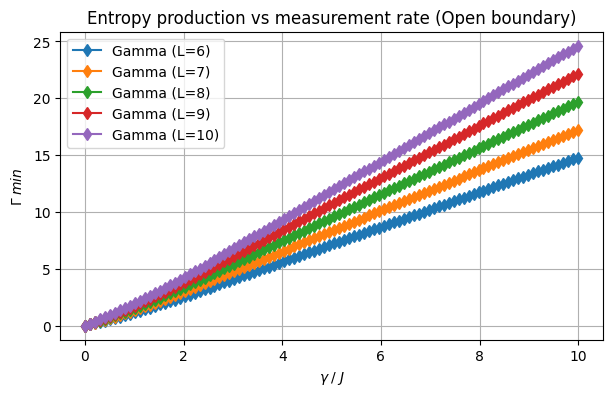

In [7]:
# Plot the entropy production per time step for each simulator
plt.figure(figsize=(7, 4))
gamma_J = gamma_values / J
gamma_min_est = [rates for rates in all_rates_arranged]
for l in L:
    plt.plot(gamma_J, gamma_min_est[l-6], 'd-', label=f'Gamma (L={l})')
plt.xlabel(r'$\gamma _ / _ J$')
plt.ylabel(r'$\Gamma _ min$')
plt.title('Entropy production vs measurement rate (Open boundary)')
plt.legend()
plt.grid(True)
plt.show()


## Area law VS Volume law
will now run some calculations to see if we can recognize a phase shift given constant gamma and growing L

In [12]:
# Simulation parameters
L = [8, 10, 12, 14, 16, 18, 20, 25, 30]         # number of sites
J = 1.0        # coherent hopping strength
N_steps = 10000 # discretisation of total time T=1

# Measurement rates to scan over
gamma_values = np.array([1, 2, 3, 4, 5])

rates_adjusted = []
all_rates_arranged = []

# Iterate over gamma values and collect entropy per time step
for l in L:
    for gamma in gamma_values:
        # Adjusted simulator: subtract γ L from the entropy budget
        sim_adj = NonHermitianAdjustedSimulator(L=l, J=J, gamma=gamma, N_steps=N_steps, closed_boundary=True)
        Q_adj, n_traj_adj = sim_adj.simulate_trajectory()
        rates_adjusted.append(Q_adj / N_steps)


    all_rates_arranged.append(np.array(rates_adjusted))
    rates_adjusted = []  # Reset for the next L value

## Compute expectation value of $n_1 = c^\dagger_1 c_1$

We'll track the occupation number of the first site over time for periodic boundary conditions.

In [16]:
# Compute expectation value of n_1 = c†_1 c_1 as a function of gamma
# For periodic boundary conditions
L = 10
J = 1.0
N_steps = 10000

gamma_values = np.linspace(0.0, 10.0, 100)
n1_values = []

for gamma in gamma_values:
    sim = NonHermitianHatSimulator(L=L, J=J, gamma=gamma, N_steps=N_steps, closed_boundary=True)
    Q, n_traj = sim.simulate_trajectory()
    # The expectation value of n_1 at the end of the trajectory
    n1_final = n_traj[-1, 0]  # Site 0 corresponds to n_1
    n1_values.append(n1_final)

n1_values = np.array(n1_values)

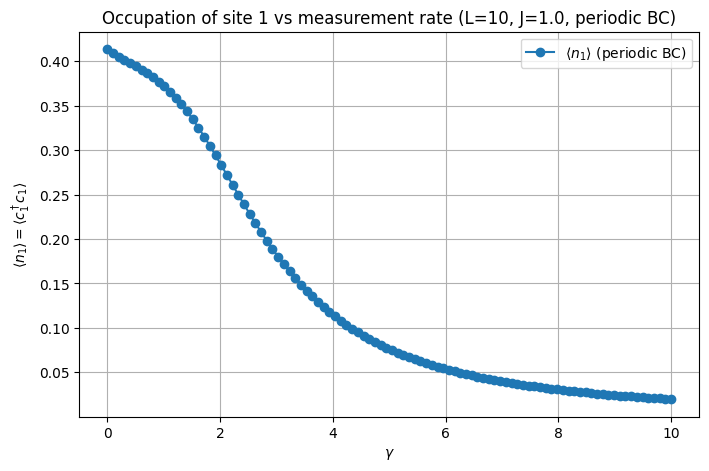

In [17]:
# Plot the expectation value of n_1 vs gamma
plt.figure(figsize=(8, 5))
plt.plot(gamma_values, n1_values, 'o-', label=r'$\langle n_1 \rangle$ (periodic BC)')
plt.xlabel(r'$\gamma$')
plt.ylabel(r'$\langle n_1 \rangle = \langle c^\dagger_1 c_1 \rangle$')
plt.title(f'Occupation of site 1 vs measurement rate (L={L}, J={J}, periodic BC)')
plt.grid(True)
plt.legend()
plt.show()

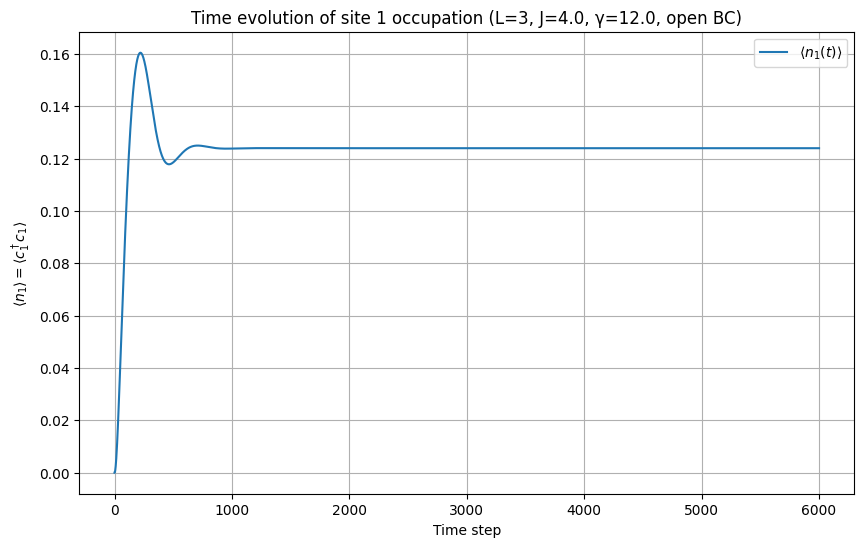

In [42]:
# Also compute time evolution of n_1 for a specific gamma value
gamma_demo = 12.0
L = 3
J = 4.0
N_steps = 6000
dt = 0.001

sim_demo = NonHermitianHatSimulator(L=L, J=J, dt=dt, gamma=gamma_demo, N_steps=N_steps, closed_boundary=True)
Q_demo, n_traj_demo = sim_demo.simulate_trajectory()


# Plot time evolution of n_1
plt.figure(figsize=(10, 6))
time_steps = np.arange(N_steps + 1)
plt.plot(time_steps, n_traj_demo[:, 0], label=r'$\langle n_1(t) \rangle$')
plt.xlabel('Time step')
plt.ylabel(r'$\langle n_1 \rangle = \langle c^\dagger_1 c_1 \rangle$')
plt.title(f'Time evolution of site 1 occupation (L={L}, J={J}, γ={gamma_demo}, open BC)')
plt.grid(True)
plt.legend()
plt.show()


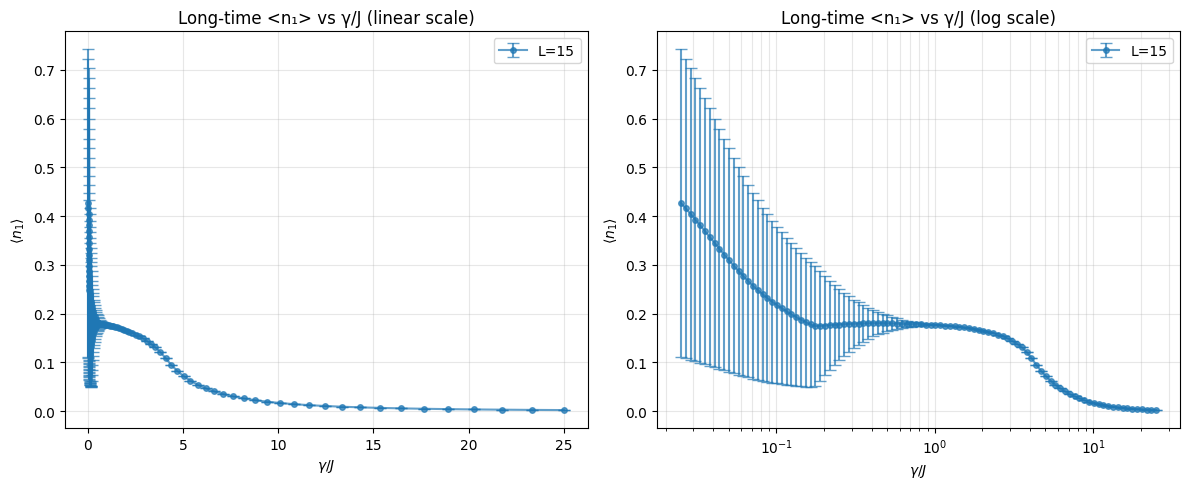

Simulation parameters:
  N_steps = 15000, dt = 0.001, T_total = 15.0
  Averaging over last 10.0% of trajectory


In [ ]:
# Long-time averaging approach for n_1 vs gamma/J
# Run long simulation, average over steady-state region

J = 4.0
L = 15
dt = 0.001
gamma_values = np.logspace(-1, 2, 100)  # gamma from 0.1 to 100 (log spacing)
N_steps = 15000  # Long simulation
steady_state_fraction = 0.1  # Use last 10% for averaging

n1_means = []
n1_stds = []

for gamma in gamma_values:
    # Run single long trajectory
    sim = NonHermitianHatSimulator(L=L, J=J, gamma=gamma, dt=dt, N_steps=N_steps, closed_boundary=True)
    Q, n_traj = sim.simulate_trajectory()
    
    # Extract steady-state region (last portion)
    start_idx = int(N_steps * (1 - steady_state_fraction))
    n1_steady = n_traj[start_idx:, 0]
    
    # Compute mean and standard deviation over time
    n1_mean = np.mean(n1_steady)
    n1_std = np.std(n1_steady)  # Variance measure
    n1_means.append(n1_mean)
    n1_stds.append(n1_std)

n1_means = np.array(n1_means)
n1_stds = np.array(n1_stds)
gamma_over_J = gamma_values / J

# Create two subplots: linear and log scale
plt.figure(figsize=(12, 5))

# Linear plot
plt.subplot(1, 2, 1)
plt.errorbar(gamma_over_J, n1_means, yerr=n1_stds, fmt='o-', 
             label=f'L={L}', capsize=4, alpha=0.7, markersize=4)
plt.xlabel(r'$\gamma/J$')
plt.ylabel(r'$\langle n_1 \rangle$')
plt.title(f'Long-time <n₁> vs γ/J (linear scale)')
plt.grid(True, alpha=0.3)
plt.legend()

# Log plot
plt.subplot(1, 2, 2)
plt.errorbar(gamma_over_J, n1_means, yerr=n1_stds, fmt='o-', 
             label=f'L={L}', capsize=4, alpha=0.7, markersize=4)
plt.xscale('log')
plt.xlabel(r'$\gamma/J$')
plt.ylabel(r'$\langle n_1 \rangle$')
plt.title(f'Long-time <n₁> vs γ/J (log scale)')
plt.grid(True, alpha=0.3, which='both')
plt.legend()

plt.tight_layout()
plt.show()

print(f"Simulation parameters:")
print(f"  N_steps = {N_steps}, dt = {sim.dt}, T_total = {sim.T_total}")
print(f"  Averaging over last {steady_state_fraction*100}% of trajectory")
